In [48]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print(device, 'with', device_name)
df = pd.read_csv('../Data/Alcohol_Sales.csv', index_col=0, parse_dates=True)

cuda with NVIDIA GeForce RTX 3070


In [50]:
print(df)
print(len(df))

            S4248SM144NCEN
DATE                      
1992-01-01            3459
1992-02-01            3458
1992-03-01            4002
1992-04-01            4564
1992-05-01            4221
...                    ...
2018-09-01           12396
2018-10-01           13914
2018-11-01           14174
2018-12-01           15504
2019-01-01           10718

[325 rows x 1 columns]
325


<AxesSubplot:xlabel='DATE'>

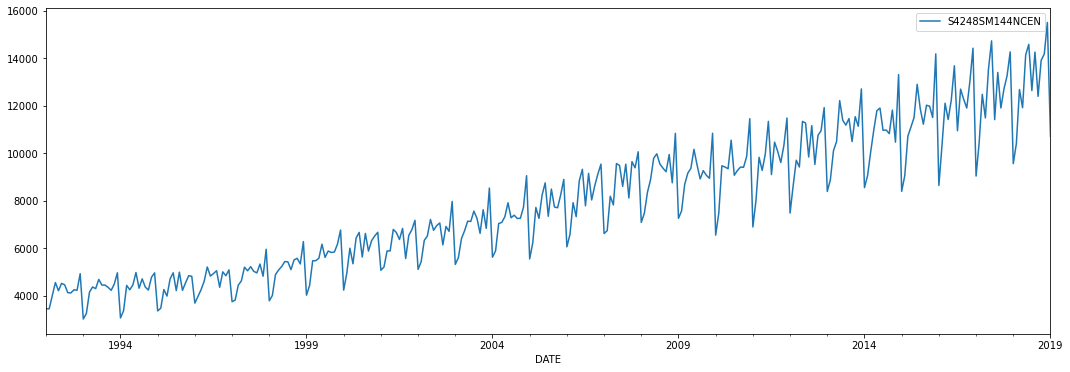

In [51]:
df.plot(figsize=(18,6))

In [52]:
y = df['S4248SM144NCEN'].values.astype(float)

In [53]:
test_size = 12
train_set = y[:-test_size]
test_size = y[-test_size:]

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

In [55]:
scaler.fit(train_set.reshape(-1,1))
train_norm = scaler.transform(train_set.reshape(-1,1))

print(train_norm)

[[-0.92683135]
 [-0.92700231]
 [-0.83400291]
 [-0.73792632]
 [-0.79656381]
 [-0.74390974]
 [-0.75467989]
 [-0.81092401]
 [-0.81280451]
 [-0.79006753]
 [-0.79331567]
 [-0.67433114]
 [-1.        ]
 [-0.9606804 ]
 [-0.80699205]
 [-0.76989486]
 [-0.7818617 ]
 [-0.71536029]
 [-0.75604753]
 [-0.75621848]
 [-0.77211727]
 [-0.79399949]
 [-0.74886742]
 [-0.66783486]
 [-0.99247799]
 [-0.94084965]
 [-0.75861185]
 [-0.78972562]
 [-0.75570562]
 [-0.66595436]
 [-0.77895547]
 [-0.71142833]
 [-0.77040773]
 [-0.79194803]
 [-0.70031627]
 [-0.66834772]
 [-0.94204633]
 [-0.92255748]
 [-0.78835798]
 [-0.83537054]
 [-0.71211215]
 [-0.66783486]
 [-0.7962219 ]
 [-0.66339003]
 [-0.79417044]
 [-0.73963587]
 [-0.6888623 ]
 [-0.69313617]
 [-0.88580221]
 [-0.83725105]
 [-0.78955466]
 [-0.72852381]
 [-0.62595094]
 [-0.69142662]
 [-0.67347637]
 [-0.65279084]
 [-0.77194632]
 [-0.66133858]
 [-0.68903325]
 [-0.64680742]
 [-0.87571587]
 [-0.8642619 ]
 [-0.75673134]
 [-0.72578853]
 [-0.62748953]
 [-0.65364561]
 [-0.62389

In [56]:
window_size = 12
epochs = 100
learning_rate = 0.01

In [57]:
train_norm = torch.FloatTensor(train_norm).view(-1)
print(train_norm)

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [58]:
def input_data(seq, ws):
    output = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        output.append((window, label))
    return output

In [59]:
train_data = input_data(train_norm, window_size)

In [60]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden_state = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))


    def forward(self, seq):
        lstm_out, self.hidden_state = self.lstm(seq.view(len(seq), 1, -1), self.hidden_state)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [61]:
model = RNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
for epoch in range(epochs):
    loss = None
    for seq, y_train in train_data:
        seq = seq.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()

        model.hidden_state = (torch.zeros(1,1,model.hidden_size).to(device), torch.zeros(1,1,model.hidden_size).to(device))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()


    print(f"Epoch: {epoch} Train Loss: {loss.item()}")


Epoch: 0 Train Loss: 0.36963388323783875
Epoch: 1 Train Loss: 0.3760937750339508
Epoch: 2 Train Loss: 0.33032673597335815
Epoch: 3 Train Loss: 0.2962702214717865
Epoch: 4 Train Loss: 0.2936101257801056
Epoch: 5 Train Loss: 0.32304227352142334
Epoch: 6 Train Loss: 0.3084489703178406
Epoch: 7 Train Loss: 0.27387169003486633
Epoch: 8 Train Loss: 0.262211412191391
Epoch: 9 Train Loss: 0.2588129937648773
Epoch: 10 Train Loss: 0.23762427270412445
Epoch: 11 Train Loss: 0.20952747762203217
Epoch: 12 Train Loss: 0.06553580611944199
Epoch: 13 Train Loss: 0.18835045397281647
Epoch: 14 Train Loss: 0.2252703756093979
Epoch: 15 Train Loss: 0.21498383581638336
Epoch: 16 Train Loss: 0.21230897307395935
Epoch: 17 Train Loss: 0.20755772292613983
Epoch: 18 Train Loss: 0.17490214109420776
Epoch: 19 Train Loss: 0.247956320643425
Epoch: 20 Train Loss: 0.33508992195129395
Epoch: 21 Train Loss: 0.2236797958612442
Epoch: 22 Train Loss: 0.20869794487953186
Epoch: 23 Train Loss: 0.16863307356834412
Epoch: 24 Tra

In [68]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)

    with torch.no_grad():
        model.hidden_state = (torch.zeros(1,1,model.hidden_size).to(device), torch.zeros(1,1,model.hidden_size).to(device))

        preds.append(model(seq).item())

In [69]:
preds[window_size:]

[0.18110430240631104,
 0.5844095945358276,
 0.3378608226776123,
 0.29551565647125244,
 1.0809783935546875,
 -0.08356022834777832,
 0.5564507246017456,
 0.12160646915435791,
 0.4915916919708252,
 0.19669783115386963,
 0.8244805335998535,
 0.14432597160339355]

In [70]:
preds_norm = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
preds_norm

array([[ 9939.86961693],
       [12299.00392324],
       [10856.81688225],
       [10609.11883253],
       [15203.6831131 ],
       [ 8391.71444428],
       [12135.45851356],
       [ 9591.83704132],
       [11756.06560218],
       [10031.08396333],
       [13703.29888129],
       [ 9724.73477089]])

In [71]:
x = np.arange('2018-02-01','2019-02-01', dtype='datetime64[M]')

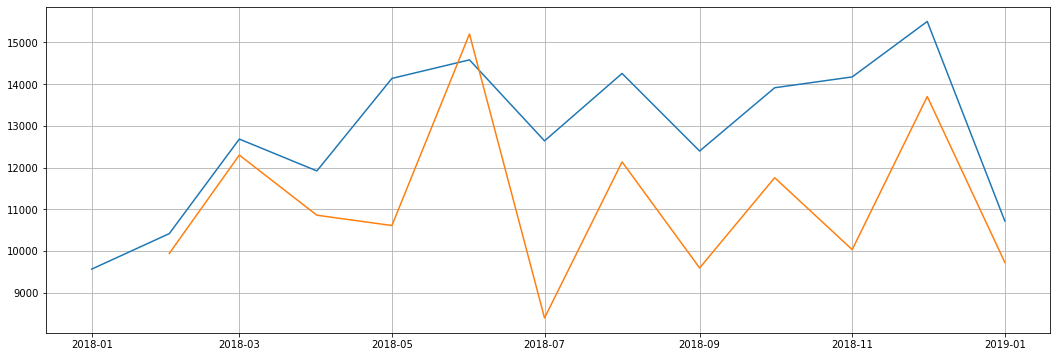

In [72]:
plt.figure(figsize=(18,6))
plt.grid(True)
plt.plot(df['S4248SM144NCEN']['2018-01-01':])
plt.plot(x, preds_norm)
plt.show()